#**Customer Segmentation**

We have more than 200,000 customer is our dataset, which we can divide into smaller segments based on common buying beviour. Since, we do not have demographics data of the customers, we can divide customer on the basis of average orders, product preference, time of the day, day of the week etc. 

In [ ]:
!pip install opendatasets --quiet 
!pip install matplotlib --quiet


import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os

In [ ]:
od.download('https://www.kaggle.com/competitions/instacart-market-basket-analysis')

#Checking the list of dataset in the directory
os.listdir('instacart-market-basket-analysis')

Skipping, found downloaded files in "./instacart-market-basket-analysis" (use force=True to force download)


['departments.csv.zip',
 'sample_submission.csv.zip',
 'order_products__prior.csv.zip',
 'orders.csv.zip',
 'products.csv.zip',
 'order_products__train.csv.zip',
 'aisles.csv.zip']

In [ ]:
from zipfile import ZipFile

with ZipFile('instacart-market-basket-analysis/aisles.csv.zip') as f:
    f.extractall(path='market-basket')
with ZipFile('instacart-market-basket-analysis/orders.csv.zip') as f:
    f.extractall(path='market-basket')
with ZipFile('instacart-market-basket-analysis/departments.csv.zip') as f:
    f.extractall(path='market-basket')  
with ZipFile('instacart-market-basket-analysis/order_products__prior.csv.zip') as f:
    f.extractall(path='market-basket')
with ZipFile('instacart-market-basket-analysis/order_products__train.csv.zip') as f:
    f.extractall(path='market-basket')
with ZipFile('instacart-market-basket-analysis/products.csv.zip') as f:
    f.extractall(path='market-basket')
os.listdir('market-basket')

['orders.csv',
 'aisles.csv',
 'order_products__train.csv',
 'order_products__prior.csv',
 'departments.csv',
 '__MACOSX',
 'products.csv']

In [ ]:
aisle = pd.read_csv('./market-basket/aisles.csv')
dept = pd.read_csv('./market-basket/departments.csv')
products = pd.read_csv('./market-basket/products.csv')
order_prior = pd.read_csv('./market-basket/order_products__prior.csv', low_memory=False )
orders = pd.read_csv('./market-basket/orders.csv', low_memory=False)

In [ ]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [ ]:
reduce_mem_usage(order_prior)
reduce_mem_usage(orders)

Memory usage of dataframe is 989.82 MB
Memory usage after optimization is: 340.25 MB
Decreased by 65.6%
Memory usage of dataframe is 182.71 MB
Memory usage after optimization is: 45.68 MB
Decreased by 75.0%


In [ ]:
aisle.shape, dept.shape, products.shape, order_prior.shape

((134, 2), (21, 2), (49688, 4), (32434489, 4))

We can cluster users on the basis of asile, department or products. However, we have more than 40,000 products, due to which our model will suffer from curse of dimensionality. Department will give us very broad prespective, so we can narrow down our clusters using aisles. Since K-mean clustering does not perform well with high dimension data, we will use Principal component analysis to reduce the dimension.

In [ ]:
#merging datasets to get user_id, order_id & aisle columns

users = order_prior.merge(orders, on = 'order_id', how = 'left').merge(products, on = 'product_id', how = 'left').merge(aisle, on = 'aisle_id', how = 'left')

users = users[['user_id', 'order_id', 'aisle', 'reordered']]

users

,user_id,order_id,aisle,reordered
0,202279,2,eggs,1
1,202279,2,fresh vegetables,1
2,202279,2,spices seasonings,0
3,202279,2,oils vinegars,1
4,202279,2,baking ingredients,0
...,...,...,...,...
32434484,25247,3421083,dish detergents,1
32434485,25247,3421083,crackers,0
32434486,25247,3421083,frozen breakfast,0
32434487,25247,3421083,fresh fruits,1


In [ ]:
#creating crosstab dataframe of all users to get number of orders for each aisle and then normalising the data
df = pd.crosstab(users['user_id'], users['aisle'])
df  = df.div(df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,...,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


In [ ]:
df.describe()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
count,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,...,206209.000000,206209.00000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000
mean,0.000785,0.005053,0.000206,0.000239,0.007688,0.001407,0.010678,0.000962,0.000234,0.002768,...,0.008917,0.00759,0.003498,0.005385,0.001483,0.001479,0.001430,0.032815,0.001650,0.038140
std,0.006687,0.014668,0.002898,0.002792,0.034536,0.011315,0.025407,0.006883,0.002852,0.026926,...,0.021392,0.02763,0.015604,0.013993,0.012919,0.010299,0.008981,0.077122,0.016968,0.059333
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016598
75%,0.000000,0.002653,0.000000,0.000000,0.000000,0.000000,0.012422,0.000000,0.000000,0.000000,...,0.010543,0.00188,0.000000,0.003650,0.000000,0.000000,0.000000,0.036145,0.000000,0.054313
max,0.625000,0.625000,0.333333,0.333333,0.906250,1.000000,1.000000,0.750000,0.454545,1.000000,...,1.000000,1.00000,1.000000,0.923077,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#importing libraries for k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

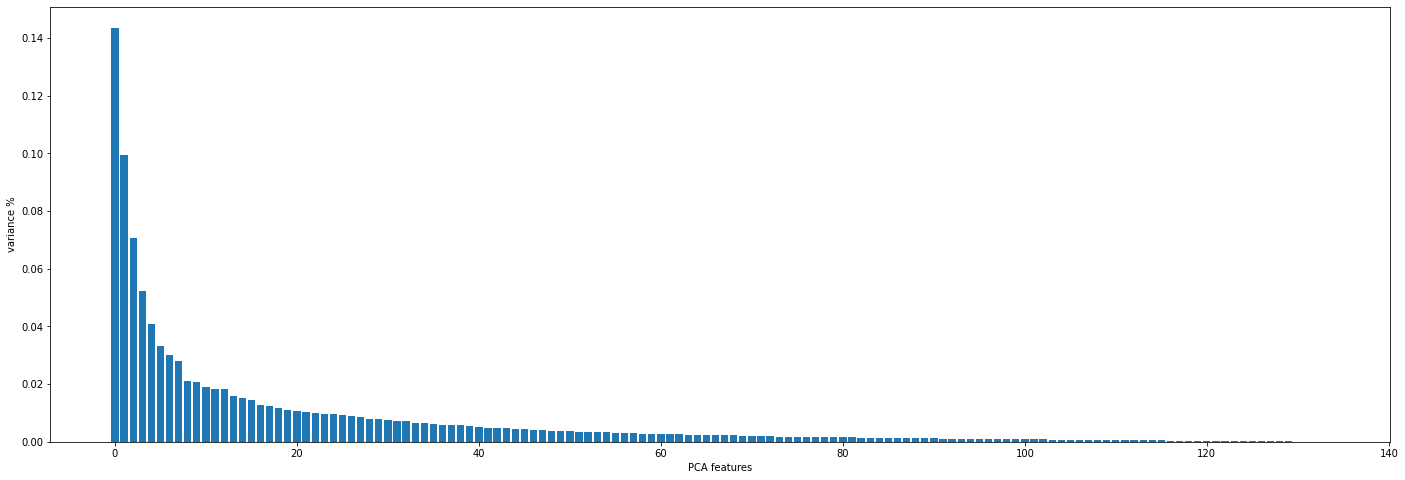

In [ ]:
pca = PCA()
pca.fit(df)

plt.figure(figsize=(24,8))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %');

In [ ]:
pca = PCA(n_components= 10)
pca.fit(df)

pca.explained_variance_ratio_.sum()

0.5390330533899678

In [ ]:
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018865,-0.088343,-0.104535,-0.116451,0.083665,-0.062125,-0.026203
1,-0.036988,0.108884,-0.066406,-0.123271,0.098847,-0.033955,-0.054741,-0.053331,-0.020108,-0.007667
2,0.064282,0.103962,0.000710,-0.012220,-0.046984,0.112243,-0.029804,0.007926,0.013366,0.003656
3,-0.093210,0.054093,0.001867,-0.003974,-0.071355,-0.019286,-0.025109,-0.038241,0.006494,-0.000502
4,0.094629,-0.037051,-0.024952,-0.021575,0.055369,0.107649,-0.008026,0.103920,0.052057,-0.025226


In [ ]:
components_df = pd.DataFrame(pca.components_)
components_df.columns = df.columns

components_df.transpose().reset_index()

,aisle,0,1,2,3,4,5,6,7,8,9
0,air fresheners candles,-0.004847,-0.001482,-0.001417,-0.000059,-0.004958,-0.000881,-0.000624,-0.003149,-0.001109,0.000959
1,asian foods,0.003750,-0.018599,-0.004750,-0.002088,-0.011310,0.004558,-0.001260,-0.015986,-0.002810,0.005293
2,baby accessories,-0.000576,-0.000060,-0.000351,-0.000582,-0.000477,0.000517,0.000761,-0.000642,-0.000772,0.000281
3,baby bath body care,-0.000793,-0.000232,-0.000717,-0.000540,-0.000508,0.000068,0.000748,-0.000341,-0.001113,-0.000208
4,baby food formula,-0.009407,0.002225,-0.032156,-0.042327,0.010371,0.011250,0.054135,-0.005857,-0.093877,-0.042041
...,...,...,...,...,...,...,...,...,...,...,...
129,trash bags liners,-0.009479,0.000493,0.004167,0.005565,-0.003969,-0.003632,0.001199,-0.002835,-0.005833,0.000124
130,vitamins supplements,-0.001797,-0.000759,-0.000354,-0.002483,-0.003352,0.004491,0.000399,-0.004911,0.000032,0.010612
131,water seltzer sparkling water,-0.263142,0.041086,0.931222,-0.135869,0.119703,0.054480,0.061024,0.007084,0.022777,-0.037775
132,white wines,-0.011803,-0.002838,-0.004883,0.007792,-0.011843,-0.003965,-0.000058,-0.008738,-0.007261,-0.002248


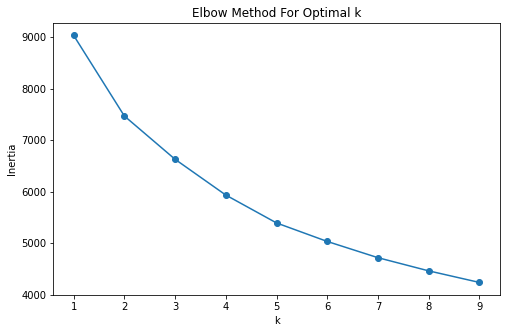

In [ ]:
interia = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    interia.append(km.inertia_)

plt.subplots(figsize = (8, 5))
plt.plot(K, interia, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
clusters = KMeans(n_clusters=5)
clusters  = clusters.fit(df_pca)

Let's create clusters in first two components.

In [ ]:
cluster_df = df_pca.iloc[:, 0:2]
prediction = clusters.predict(df_pca)
cluster_df['cluster']  = prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
cluster_df.head()

,0,1,cluster
0,-0.113443,0.039084,3
1,-0.036988,0.108884,1
2,0.064282,0.103962,1
3,-0.093210,0.054093,3
4,0.094629,-0.037051,2


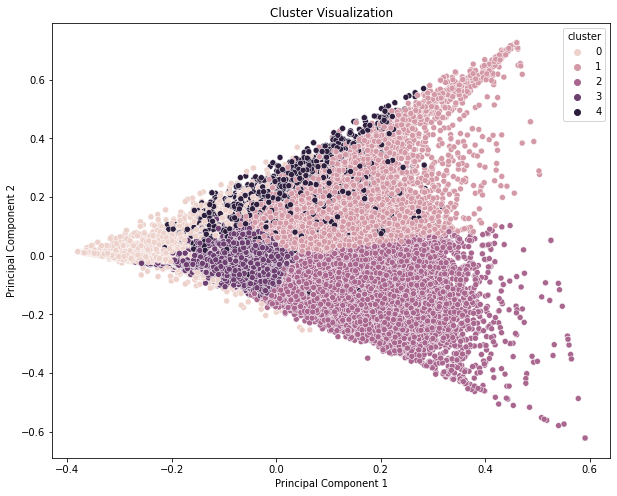

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.scatterplot(data = cluster_df, x = 0, y = 1, hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

In [ ]:
df['clusters'] = prediction

In [ ]:
df['clusters'].value_counts().sort_values(ascending = False)

3    99150
2    55847
1    37846
4     7949
0     5417
Name: clusters, dtype: int64

In [ ]:
df

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,clusters
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.016949,3
2,0.0,0.015385,0.00000,0.0,0.000000,0.0,0.010256,0.000000,0.0,0.0,...,0.005128,0.005128,0.000000,0.000000,0.000000,0.0,0.010256,0.0,0.215385,1
3,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.011364,0.000000,0.000000,0.000000,0.000000,0.0,0.022727,0.0,0.000000,1
4,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.055556,0.000000,0.000000,0.0,0.055556,0.0,0.000000,3
5,0.0,0.054054,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.081081,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.0,0.000000,0.03125,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.156250,3
206206,0.0,0.014035,0.00000,0.0,0.000000,0.0,0.014035,0.003509,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.003509,0.0,0.003509,0.0,0.000000,3
206207,0.0,0.000000,0.00000,0.0,0.004484,0.0,0.000000,0.000000,0.0,0.0,...,0.017937,0.000000,0.008969,0.004484,0.000000,0.0,0.049327,0.0,0.067265,3


In [ ]:
duplicate = df.drop(['fresh fruits', 'fresh vegetables'], axis = 1) #removing fresh fruits & vegetable

for x in range(0,5):
  cluster = duplicate[duplicate.clusters == x]

  print("="*40)
  print('cluster', x )
  
  print(cluster.drop('clusters', axis = 1).mean().sort_values(ascending=False)[0:10])

cluster 0
aisle
water seltzer sparkling water    0.388493
soft drinks                      0.052726
packaged vegetables fruits       0.018741
paper goods                      0.017529
yogurt                           0.017466
chips pretzels                   0.016770
milk                             0.016046
packaged produce                 0.015691
candy chocolate                  0.014465
juice nectars                    0.013962
dtype: float64
cluster 1
aisle
packaged vegetables fruits       0.070770
yogurt                           0.048830
milk                             0.031863
packaged cheese                  0.025342
soy lactosefree                  0.021827
water seltzer sparkling water    0.021658
frozen produce                   0.018045
bread                            0.017370
chips pretzels                   0.017182
refrigerated                     0.016815
dtype: float64
cluster 2
aisle
packaged vegetables fruits       0.066743
yogurt                           0.03134

From above table we can see a pattern of product preference among clusters:
* Cluster 0 has strong preference for drinks such as seltzer, sparkling water, soft drinks, juices, and also candies & chocolate. 
* Cluster 1 buys regular grocery items such as packaged vegetables fruits, bread, milk, egg & yogurt.
* Cluster 2 differs from cluster 1 in terms of their preference for fresh herbs.
* Cluster 3 orders refrigerated items, frozen meals and ice cream aside from staples.
* Cluster 4 mostly orders frozen produce aside from packaged vegetables & fruits. Their basket also contain oils, vinegar, and nuts, seeds & dried fruits.

Now, let look at the average hour, orders, day of the week, number or products for each cluster.


In [ ]:
df = df.reset_index()
user_cluster = df[['user_id', 'clusters']]

In [ ]:
user_cluster_merged = user_cluster.merge(orders, on = 'user_id', how = 'inner').merge(order_prior, on = 'order_id', how = 'inner').merge(products, on = 'product_id', how = 'left').merge(aisle, on = 'aisle_id', how = 'left')


In [ ]:
user_cluster_merged= user_cluster_merged.drop(['eval_set', 'product_id', 'aisle_id', 'department_id'], axis = 1)
user_cluster_merged.head()

,user_id,clusters,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,aisle
0,1,3,2539329,1,2,8,NaN,1,0,Soda,soft drinks
1,1,3,2539329,1,2,8,NaN,2,0,Organic Unsweetened Vanilla Almond Milk,soy lactosefree
2,1,3,2539329,1,2,8,NaN,3,0,Original Beef Jerky,popcorn jerky
3,1,3,2539329,1,2,8,NaN,4,0,Aged White Cheddar Popcorn,popcorn jerky
4,1,3,2539329,1,2,8,NaN,5,0,XL Pick-A-Size Paper Towel Rolls,paper goods


In [ ]:
analysis = user_cluster_merged.groupby('user_id')['order_id'].agg(['count','nunique']).reset_index()
analysis.columns = ['user_id','total_products','total_orders']

analysis['average_cart_size'] = analysis['total_products']/analysis['total_orders']

In [ ]:
info = user_cluster_merged.groupby('user_id')['order_hour_of_day'].mean().round().reset_index()

analysis = analysis.merge(info, on = 'user_id', how = 'left').merge(user_cluster, on = 'user_id',how = 'left')

In [ ]:
analysis.drop('user_id', axis = 1).groupby('clusters').mean()

,total_products,total_orders,average_cart_size,order_dow,order_hour_of_day
clusters,,,,,
0,62.996493,12.815581,4.372913,2.831457,13.047259
1,175.244094,17.782196,9.553134,2.666596,13.488057
2,180.987448,16.048776,11.444275,2.653142,13.659051
3,149.568301,14.755451,10.000485,2.825759,13.568805
4,65.875708,14.239275,4.553286,2.835954,13.108945


Combining knowledge from aisle preference and order pattern, we can infer following personas:
* Cluster_0 users are in their early 20s, living by themselves who usually orders snacks and drinks, due to which their average number of orders and cart size is less. 
* Cluster_1 and cluster_2 users are family with high order frequency because they regulary buy staples like fruits, vegetables, eggs, yogurt milk etc. 
* Cluster_3 has high average cart size but low average number of orders because they usually buy frozen products due to which they do not have to buy that often but when they do buy, they order large number of products.
* Cluster_4 also have low average number of orders because they buy long shelf life products such as seltzers, oils, vinegar, nuts, seeds, dried fruits and frozen produce.